In this notebook, I will use what we already created in our initial midterm notebooks and improve upon it so as to make a better product for our final. To start, we're going to bring back in our original trees dataframe as well as our three Census variables.

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from sklearn import linear_model
oaktrees=gpd.read_file('https://opendata.arcgis.com/datasets/385456a220174ef1854738b4029df3fd_0.geojson')

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [5]:
oakincome=gpd.read_file('oakdata.geojson')
oakrace=gpd.read_file('oakrace.geojson')
oakeduc=gpd.read_file('oakeduc.geojson')

And just quickly paste over our data cleaning...

In [6]:
oakincome.columns = ['geoid',
                   'name',
                   'Median Income',
                   'Margin Of Error',
                   'geometry']

In [7]:
oakincome=oakincome.drop([337])

In [8]:
oakrace_columnstokeep=['geoid',
                       'name',
                       'B03002001',
                       'B03002002',
                       'B03002003',
                       'B03002004',
                       'B03002005',
                       'B03002006',
                       'B03002007',
                       'B03002008',
                       'B03002009',
                       'B03002012',
                       'geometry']
oakrace=oakrace[oakrace_columnstokeep]

In [9]:
oakrace=oakrace.drop([337])

In [10]:
oakrace.columns= ['geoid', 'name', 
                   'Total', 
                   'Not Hispanic or Latino', 
                   'White alone', 
                   'Black or African American alone', 
                   'American Indian and Alaska Native alone',
                   'Asian alone',
                   'Native Hawaiian and Other Pacific Islander alone',
                   'Some other race alone',
                   'Two or more races',
                   'Hispanic or Latino',
                   'geometry']
oakrace['Percent Non Hispanic'] = oakrace['Not Hispanic or Latino']/oakrace['Total']*100
oakrace['Percent White'] = oakrace['White alone']/oakrace['Total']*100
oakrace['Percent Black'] = oakrace['Black or African American alone']/oakrace['Total']*100
oakrace['Percent Native American'] = oakrace['American Indian and Alaska Native alone']/oakrace['Total']*100
oakrace['Percent Asian'] = oakrace['Asian alone']/oakrace['Total']*100
oakrace['Percent Hawaiian/PI'] = oakrace['Native Hawaiian and Other Pacific Islander alone']/oakrace['Total']*100
oakrace['Percent other race'] = oakrace['Some other race alone']/oakrace['Total']*100
oakrace['Percent two or more races'] = oakrace['Two or more races']/oakrace['Total']*100
oakrace['Percent Hispanic/Latino'] = oakrace['Hispanic or Latino']/oakrace['Total']*100

In [11]:
oakeduc['High school or less']=oakeduc['B15003002']+oakeduc['B15003003']+oakeduc['B15003004']+oakeduc['B15003005']+oakeduc['B15003006']+oakeduc['B15003007']+oakeduc['B15003008']+oakeduc['B15003009']+oakeduc['B15003010']+oakeduc['B15003011']+oakeduc['B15003012']+oakeduc['B15003013']+oakeduc['B15003014']+oakeduc['B15003015']+oakeduc['B15003016']+oakeduc['B15003017']
oakeduc['Some college']=oakeduc['B15003019']+oakeduc['B15003020']

In [12]:
oakeduccol=['geoid',
            'name',
            'B15003001',
            'B15003018',
            'B15003021',
            'B15003022',
            'B15003023',
            'B15003024',
            'B15003025',
            'geometry',
            'High school or less',
            'Some college']
oakeduc=oakeduc[oakeduccol]

In [13]:
oakeduc.columns=['geoid',
                 'name',
                 'Total',
                 'GED',
                 'Associates',
                 'Bachelor',
                 'Master',
                 'Professional school',
                 'Doctorate',
                 'geometry',
                 'High school or less',
                 'Some college']

In [14]:
oakeduc=oakeduc.drop([337])

In [15]:
oakeduc['Percent GED'] = oakeduc['GED']/oakeduc['Total']*100
oakeduc['Percent Associates'] = oakeduc['Associates']/oakeduc['Total']*100
oakeduc['Percent Bachelor'] = oakeduc['Bachelor']/oakeduc['Total']*100
oakeduc['Percent Master'] = oakeduc['Master']/oakeduc['Total']*100
oakeduc['Percent Professional school'] = oakeduc['Professional school']/oakeduc['Total']*100
oakeduc['Percent Doctorate'] = oakeduc['Doctorate']/oakeduc['Total']*100
oakeduc['Percent High school or less'] = oakeduc['High school or less']/oakeduc['Total']*100
oakeduc['Percent Some college'] = oakeduc['Some college']/oakeduc['Total']*100

In [16]:
oakeduc['Percent Higher Ed']=oakeduc['Percent Bachelor']+oakeduc['Percent Master']+oakeduc['Percent Doctorate']

Finally, we're going to complete our merge of the trees datasets with the Census variables.

In [17]:
oakmerge=gpd.sjoin(oakincome,oaktrees)
oaktrees_income=oakmerge.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_income=oakincome.merge(oaktrees_income,how='left',on='geoid')

In [18]:
oakmerge2=gpd.sjoin(oakrace,oaktrees)
oaktrees_race=oakmerge2.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_race=oakrace.merge(oaktrees_race,how='left',on='geoid')

In [19]:
oakmerge3=gpd.sjoin(oakeduc,oaktrees)
oaktrees_educ=oakmerge3.value_counts('geoid').reset_index(name='trees in census block')
oak_trees_educ=oakeduc.merge(oaktrees_educ,how='left',on='geoid')

Now our various dataframes are exactly where they were at the midterm stage. However, after running our initial analysis, we realized that the data was distorted by the influence of census blocks in the hills, which have very few to no right-of-way street trees and generally high incomes. Thankfully, by removing just the census blocks with a null value for "trees in census block," most of the hills blocks are eliminated. We'll start there, and then remove the handful of census blocks with fewer than 100 people or fewer than 10 street trees.

In [20]:
almostcleanoakincome=oak_trees_income.dropna(subset=['trees in census block'])

In [21]:
yuckyoakincome=almostcleanoakincome[(almostcleanoakincome['trees in census block'] <= 10)].index
cleanoakincome=almostcleanoakincome.drop(yuckyoakincome)

In [22]:
oak1=oak_trees_race.dropna(subset=['trees in census block'])

In [23]:
badoakrace=oak1[(oak1['Total'] <= 100)].index
almostcleanoakrace=oak1.drop(badoakrace)

In [24]:
yuckyoakrace=almostcleanoakrace[(almostcleanoakrace['trees in census block'] <= 10)].index
cleanoakrace=almostcleanoakrace.drop(yuckyoakrace)

In [25]:
oaked=oak_trees_educ.dropna(subset=['trees in census block'])

In [26]:
badoakeduc=oaked[(oaked['Total'] <= 100)].index
almostcleanoakeduc=oaked.drop(badoakeduc)

In [27]:
yuckyoakeduc=almostcleanoakeduc[(almostcleanoakeduc['trees in census block'] <= 10)].index
cleanoakeduc=almostcleanoakeduc.drop(yuckyoakeduc)

Fantastic! After some wrangling, each of the dataframes are even cleaner than they were on the midterm, which means it's time to make some sweet basemaps. Below, I will convert each Census variable dataframe into the relevant coordinate projection, and then I will lay the data down on a basemap of the city of Oakland, California.

In [28]:
oakincome_mercator = cleanoakincome.to_crs(epsg=3857)

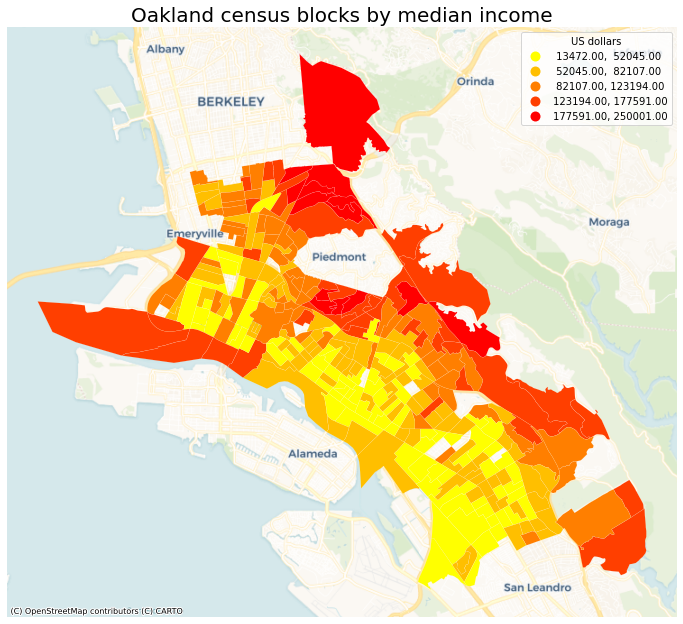

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
oakincome_mercator.plot(column='Median Income', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("Oakland census blocks by median income",fontsize=20)
ax.get_legend().set_title("US dollars")
ctx.add_basemap(ax, crs=oakincome_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('censusblocks.png')

In [30]:
oakeduc_mercator = cleanoakeduc.to_crs(epsg=3857)

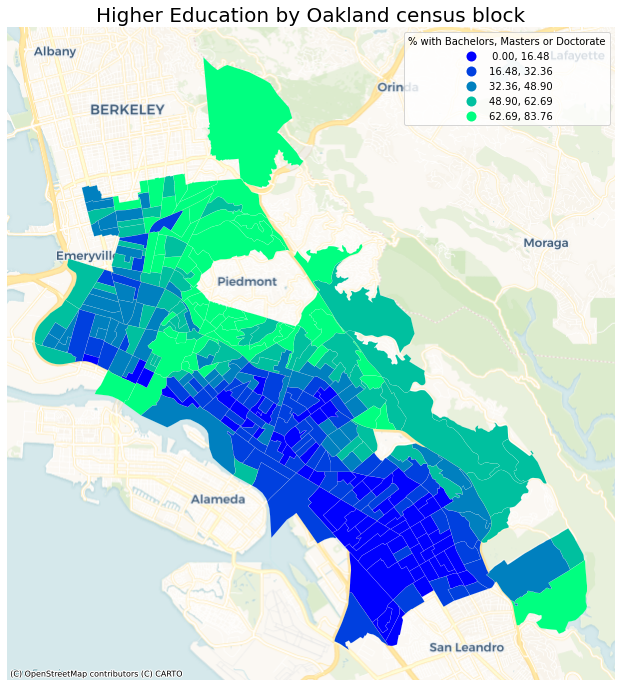

In [31]:
fig, ax = plt.subplots(figsize=(12, 12))
oakeduc_mercator.plot(column='Percent Higher Ed', 
            cmap='winter', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True)
           )
ax.axis("off")
ax.set_title("Higher Education by Oakland census block",fontsize=20)
ax.get_legend().set_title("% with Bachelors, Masters or Doctorate")
ctx.add_basemap(ax, crs=oakeduc_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('highered.png')

In [32]:
oakrace_mercator = cleanoakrace.to_crs(epsg=3857)

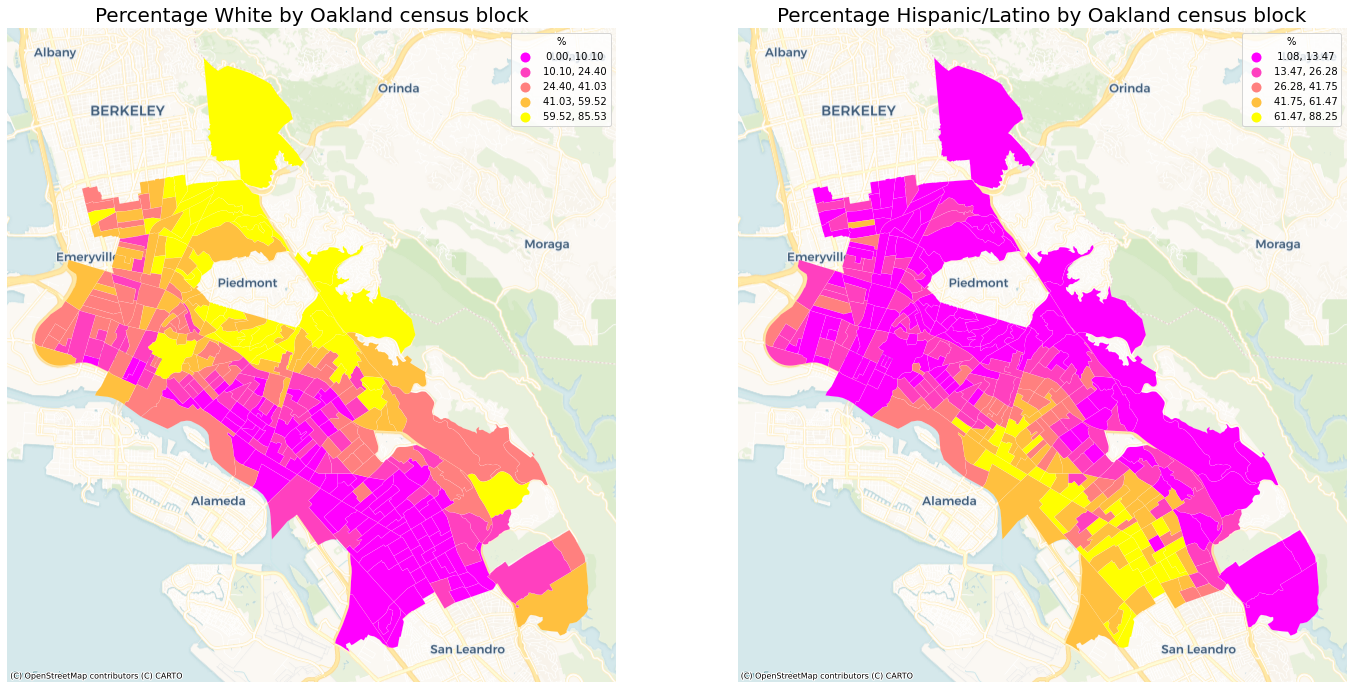

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=True, sharey=True)
ax1, ax2 = axs

oakrace_mercator.plot(column='Percent White', 
            cmap='spring', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax1,
            legend=(True)
           )
ax1.axis("off")
ax1.set_title("Percentage White by Oakland census block",fontsize=20)
ax1.get_legend().set_title("%")
ctx.add_basemap(ax1, crs=oakrace_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

oakrace_mercator.plot(column='Percent Hispanic/Latino', 
            cmap='spring', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax2,
            legend=(True)
           )
ax2.axis("off")
ax2.set_title("Percentage Hispanic/Latino by Oakland census block",fontsize=20)
ax2.get_legend().set_title("%")
ctx.add_basemap(ax2, crs=oakrace_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('oakrace.png')

After removing the hills blocks from our dataframe, the spatial patterns present themselves even more clearly. As we can see, these various markers of privilege -- wealth, higher education, and whiteness -- cluster in North Oakland, the Oakland hills, and in the areas surrounding Piedmont, which is an extremely wealthy city-within-a-city completely contained within Oakland. (We've also added a side-by-side with percentage of Hispanic/Latino individuals in a census block to better contextualize the whiteness map.)

For our trees map, we decided to make a slight modification: instead of simply counting the number of trees in a given census block, we thought it'd be more informative to normalize the data by counting trees per square kilometer. Below, we create a new variable called "area" in our dataframe using the geopandas .area command, which, for this dataframe, spits out the number of square meters in the census block polygon. We then divide those by 1,000,000 to get the square kilometers.

After creating an area column, we create our "trees per sq km" column by dividing trees in census block by area. The map that follows reflects this normalization.

In [43]:
oakincome_mercator.head()
oakincome_mercator['area']=oakincome_mercator.area/(10**6)

In [44]:
oakincome_mercator.sort_values(by='trees in census block',inplace=True,ascending=False)

In [45]:
oakincome_mercator['trees per sq km']=oakincome_mercator['trees in census block']/oakincome_mercator['area']

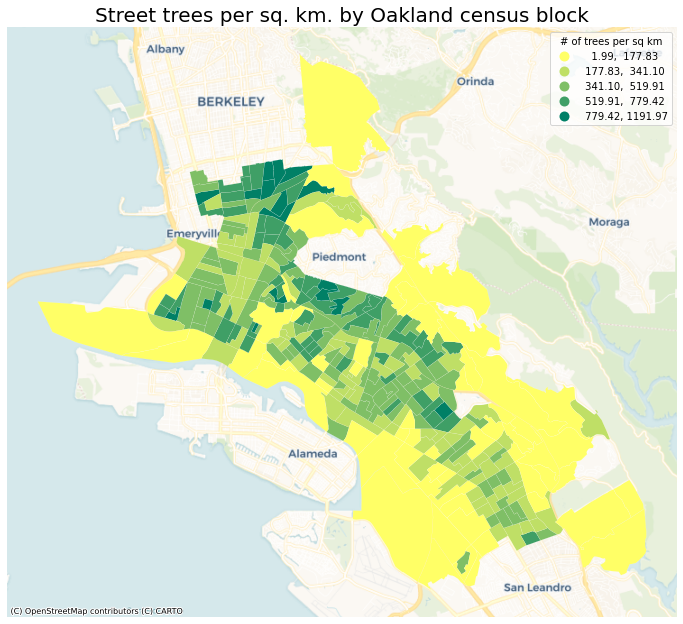

In [47]:
fig, ax = plt.subplots(figsize=(12, 12))
oakincome_mercator.plot(column='trees per sq km', 
            cmap='summer_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True)
           )
ax.axis("off")
ax.set_title("Street trees per sq. km. by Oakland census block",fontsize=20)
ax.get_legend().set_title("# of trees per sq km")
ctx.add_basemap(ax, crs=oakincome_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)
plt.savefig('oaktrees.png')

Now that we've got our new and improved maps, it's time to step up our statistics game. In the previous notebook, our scatterplots didn't have lines of best fit, included null valued observations, didn't do any math to measure the strength of the relationships between the two measured variables. Here, we've fixed all of that.

A note on methodology: We decided to use "trees in census block" instead of the normalized "trees per sq km" because we are primarily interested in trees per person, not trees per unit of area, so it makes sense to compare the quantity of trees across census blocks because they contain roughly the same amount of residents.

Below, we create a new dataframe that drops null values in the "Median Income" column. Then, we use the numpy library to create a line of best fit for our scatterplot with the number of trees in the census block on the x-axis and the median income of the census block on the y-axis. Finally, we use matplotlib to present the scatterplot.

In [59]:
oakincome_corr=cleanoakincome.dropna(subset=['Median Income'])

In [61]:
a=oakincome_corr['trees in census block']
e=oakincome_corr['Median Income']
c=np.array(oakincome_corr['trees in census block'])
d=np.array(oakincome_corr['Median Income'])
m, b = np.polyfit(c, d, 1)

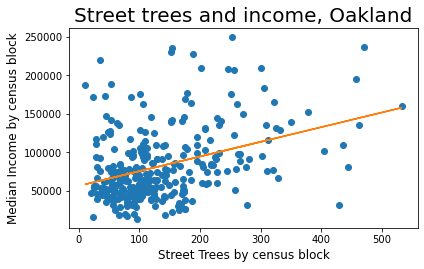

In [62]:
plt.plot(a,e,'o')
plt.plot(c, m*c + b)
plt.title(label="Street trees and income, Oakland",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Median Income by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scatterincome.png')

After the plot is done, we used numpy's .corrcoef command to give us the correlation coefficient. In this case, we get a 0.37 correlation coefficient, which is considered a moderately strong relationship.

In [63]:
np.corrcoef(oakincome_corr['Median Income'], oakincome_corr['trees in census block'])

array([[1.        , 0.37275766],
       [0.37275766, 1.        ]])

We then repeated this process for our other two variables of concern: educational attainment and race.

In [64]:
oakeduc_corr=cleanoakeduc.dropna(subset=['Percent Higher Ed'])

In [65]:
f=oakeduc_corr['trees in census block']
g=oakeduc_corr['Percent Higher Ed']
h=np.array(oakeduc_corr['trees in census block'])
i=np.array(oakeduc_corr['Percent Higher Ed'])
mm, bb = np.polyfit(h, i, 1)

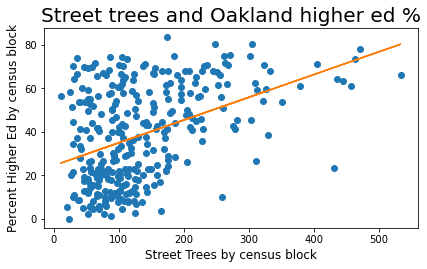

In [66]:
plt.plot(f,g,'o')
plt.plot(h, mm*h + bb)
plt.title(label="Street trees and Oakland higher ed %",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Percent Higher Ed by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scattered.png')

In [67]:
np.corrcoef(oakeduc_corr['Percent Higher Ed'], oakeduc_corr['trees in census block'])

array([[1.        , 0.42581632],
       [0.42581632, 1.        ]])

In [68]:
oakrace_corr=cleanoakrace.dropna(subset=['Percent White'])

In [69]:
j=oakrace_corr['trees in census block']
k=oakrace_corr['Percent White']
l=np.array(oakrace_corr['trees in census block'])
n=np.array(oakrace_corr['Percent White'])
mmm, bbb = np.polyfit(l, n, 1)

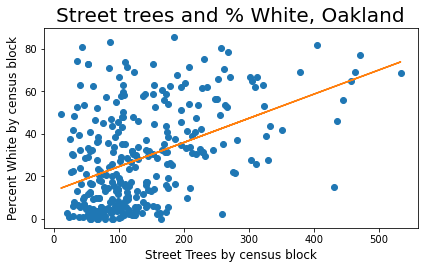

In [70]:
plt.plot(j,k,'o')
plt.plot(l, mmm*l + bbb)
plt.title(label="Street trees and % White, Oakland",
          fontsize=20,
          color="black",)
plt.xlabel('Street Trees by census block', fontsize=12)
plt.ylabel('Percent White by census block', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('scatterrace.png')

In [48]:
np.corrcoef(oakrace_corr['Percent White'], oakrace_corr['trees in census block'])

array([[1.        , 0.44593007],
       [0.44593007, 1.        ]])

As we can see in each of these scatterplots, there are relatively strong relationships between the number of street trees and these markers of privilege.

To complete our analysis, we were interested in seeing if we could build a multivariate predictive model with each of our three variables of interest. In order to do so, we had to merge all of our variables into one model, which we did below.

In [71]:
oak_income_race = oak_trees_income.merge(oak_trees_race, how="left", on='geoid')

In [72]:
oak_income_race_educ = oak_income_race.merge(oak_trees_educ, how="left", on='geoid')

After the inclusive dataframe was created, we trimmed it a bit further...

In [73]:
coltokeep=['geoid','Median Income','Percent White','Percent Higher Ed','trees in census block','geometry']

In [74]:
oak_income_race_educ=oak_income_race_educ[coltokeep]

We dropped all of the null values...

In [75]:
oakmodel=oak_income_race_educ.dropna(subset=['trees in census block'])

In [76]:
oak_model=oakmodel.dropna(subset=['Median Income'])

And after all of that additional cleaning, we borrowed the linear_mode.LinearRegression command from the sklearn library in order to build a model that takes a user-generated value for each of our variables of concern and then predicts how many trees would be in that theoretical census block.

In [77]:
reg = linear_model.LinearRegression()

In [78]:
reg.fit(oak_model[['Median Income','Percent Higher Ed','Percent White']],oak_model['trees in census block'])

LinearRegression()

Below, you can see the coefficients for our regression equation as well as the intercept. The intercept essentially tells us that a census block with a median income of zero dollars, zero residents with a higher education degree, and zero white individuals would have 72 street trees. 

In [79]:
reg.coef_

array([1.19434167e-04, 6.24180219e-01, 9.59563840e-01])

In [81]:
reg.intercept_

72.36763172019728

Here, we can see a census block with a median income of 200,000 dollars, 75 percent of its residents with a tertiary education, and a 75 percent white population would be predicted to have 215 trees. 

In [82]:
reg.predict([[200000,75,75]])

array([215.03526947])

Let's compare that to a census block with a median income of 40,000 dollars, 15 percent of its residents with a tertiary education, and a 15 percent white population...

In [83]:
reg.predict([[40000,15,15]])

array([100.90115927])

Only 100 trees!

Our project began with us asking a research question: Are trees are equally distributed across the city of Oakland, or are there variations that can be predicted by socioeconomic indicators? After 10 weeks of work, we can see the answer right here in this predictive model. As privilege markers increase, the number of street trees in a given census block also increases.